<a href="https://www.kaggle.com/code/fareshamdy/mask-detection-using-cnn-mobilenetv2-ipynb?scriptVersionId=195951068" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Face Mask Detection Project using MobileNetV2

**Author**: Faris Hamdi

**Description**: This project implements a face mask detection model using MobileNetV2 with transfer learning. 

**The project includes data preprocessing, model training, evaluation, fine-tuning, and testing on new images.**


# Importing Libraries and Packages
--------
- In this section, we import all the necessary libraries and packages required for the project.

- These include libraries for deep learning (TensorFlow, Keras), data preprocessing, visualization, and image manipulation.

In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from keras import layers
from glob import glob
import keras

# Loading and Visualizing Dataset
-----
- In this section, we specify the paths to the dataset directories. The dataset consists of images of people wearing masks correctly, incorrectly, or without masks. 

- We then load a few example images from each category and visualize them.


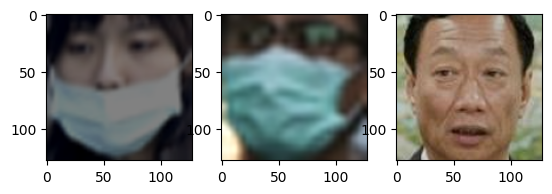

In [2]:
dataset_path = '/kaggle/input/face-mask-detection/Dataset'
mask_weared_incorrect = glob('/kaggle/input/face-mask-detection/Dataset/mask_weared_incorrect/*.png')
with_mask = glob('/kaggle/input/face-mask-detection/Dataset/with_mask/*.png')
without_mask = glob('/kaggle/input/face-mask-detection/Dataset/without_mask/*.png')

# Visualize sample images
fig, ax = plt.subplots(1,3)
ax[0].imshow(plt.imread(mask_weared_incorrect[0]))
ax[1].imshow(plt.imread(with_mask[0]))
ax[2].imshow(plt.imread(without_mask[0]))
plt.show()

# Data Preprocessing and Augmentation
-----------------------------------------------------
- We use ImageDataGenerator to apply data augmentation techniques such as rescaling, zooming, and flipping. 

- This helps in generating more diverse training data and reducing overfitting.

- We also split the dataset into training and validation sets, specifying the target size (224,224) for MobileNetV2.


Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


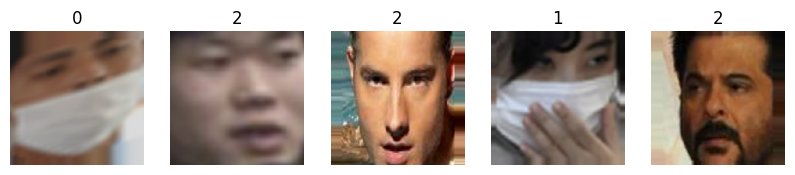

In [3]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2  # 80% training, 20% validation
)

# Updated image size to (224,224)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

# Visualizing a batch of training images and their labels
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))  # Display class
    plt.axis('off')
plt.show()

# Building the Model using MobileNetV2
-----------------------------------------------------
- We use the MobileNetV2 architecture, pre-trained on ImageNet, as the base model for transfer learning. 

- The model's top layers are replaced with custom layers suitable for our 3-class classification task (mask_weared_incorrect, with_mask, without_mask).

In [4]:
base_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Output 3 classes

model = Model(inputs= base_model.input, outputs = x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Adding Callbacks (Model Checkpointing and Early Stopping)
-----------------------------------------------------
- In this section, we implement ModelCheckpoint to save the best-performing model based on validation accuracy.

- We also apply EarlyStopping to stop training if the validation performance degrades after a certain number of epochs.


In [5]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Training the Model
 -----------------------------------------------------
- We train the model for 20 epochs using the training data, with validation data being used to monitor performance.

- ModelCheckpoint and EarlyStopping callbacks are used to optimize the training process.


In [6]:
history = model.fit(
    train_generator,
    epochs=20,  # Increased number of epochs
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop]  # Add callbacks
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725895428.036184      82 service.cc:145] XLA service 0x7ba644004a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725895428.036244      82 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/225 ━━━━━━━━━━━━━━━━━━━━ 50:56 14s/step - accuracy: 0.3438 - loss: 1.2252

I0000 00:00:1725895432.763718      82 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8799 - loss: 0.3013
Epoch 1: val_accuracy improved from -inf to 0.95206, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 153s 624ms/step - accuracy: 0.8803 - loss: 0.3004 - val_accuracy: 0.9521 - val_loss: 0.1387
Epoch 2/20
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9629 - loss: 0.1022
Epoch 2: val_accuracy did not improve from 0.95206
225/225 ━━━━━━━━━━━━━━━━━━━━ 107s 465ms/step - accuracy: 0.9628 - loss: 0.1022 - val_accuracy: 0.9404 - val_loss: 0.1716
Epoch 3/20
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9617 - loss: 0.0941
Epoch 3: val_accuracy improved from 0.95206 to 0.96265, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 103s 449ms/step - accuracy: 0.9618 - loss: 0.0941 - val_accuracy: 0.9627 - val_loss: 0.1198
Epoch 4/20
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9754 - loss: 0.0737
Epoch 4: val_accuracy did not improve from 0.96265
225/225 ━━━━━━━━━━━

# Model Evaluation on Validation Data
-----------------------------------------------------
- After training, we load the best model and evaluate its performance on the validation set.

- The accuracy of the model is printed as a percentage.


In [7]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 355ms/step - accuracy: 0.9773 - loss: 0.0725
Validation Accuracy: 97.71%


# Fine-Tuning the Model (Unfreezing MobileNetV2)
-----------------------------------------------------
- We unfreeze the MobileNetV2 base model and fine-tune the entire model with a lower learning rate.
- Fine-tuning helps improve the model's performance by allowing it to adjust the weights of pre-trained layers.

```
base_model.trainable = True

# Recompile with lower learning rate
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,  # Additional epochs for fine-tuning
    callbacks=[checkpoint, early_stop]  # Same callbacks
)
```

# Detailed Evaluation using Confusion Matrix and Classification Report
-----------------------------------------------------
- In this section, we evaluate the model's performance using a confusion matrix and a classification report.

- These metrics provide insights into the precision, recall, and F1-score of the model for each class.


57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 397ms/step


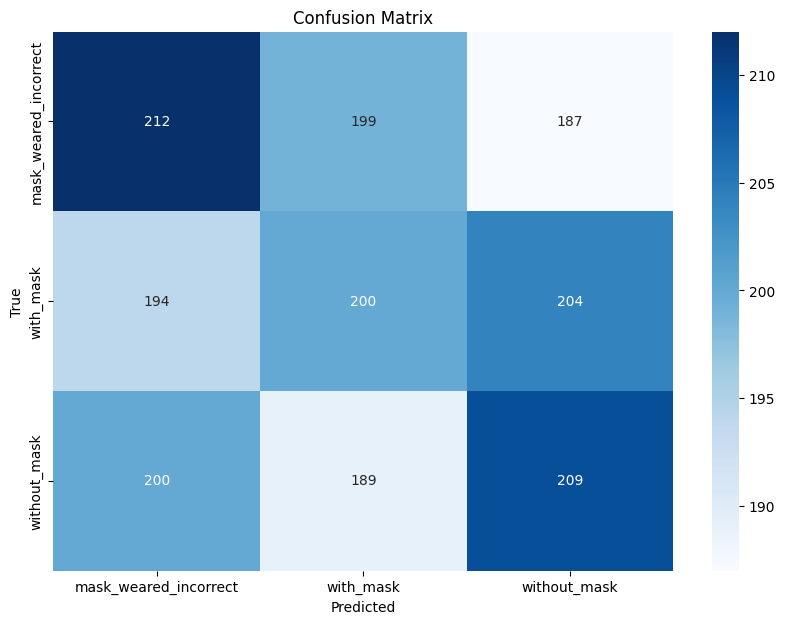

Classification Report:
                        precision    recall  f1-score   support

mask_weared_incorrect       0.35      0.35      0.35       598
            with_mask       0.34      0.33      0.34       598
         without_mask       0.35      0.35      0.35       598

             accuracy                           0.35      1794
            macro avg       0.35      0.35      0.35      1794
         weighted avg       0.35      0.35      0.35      1794



In [8]:
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=validation_generator.class_indices.keys(), 
            yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
target_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']
print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=target_names))


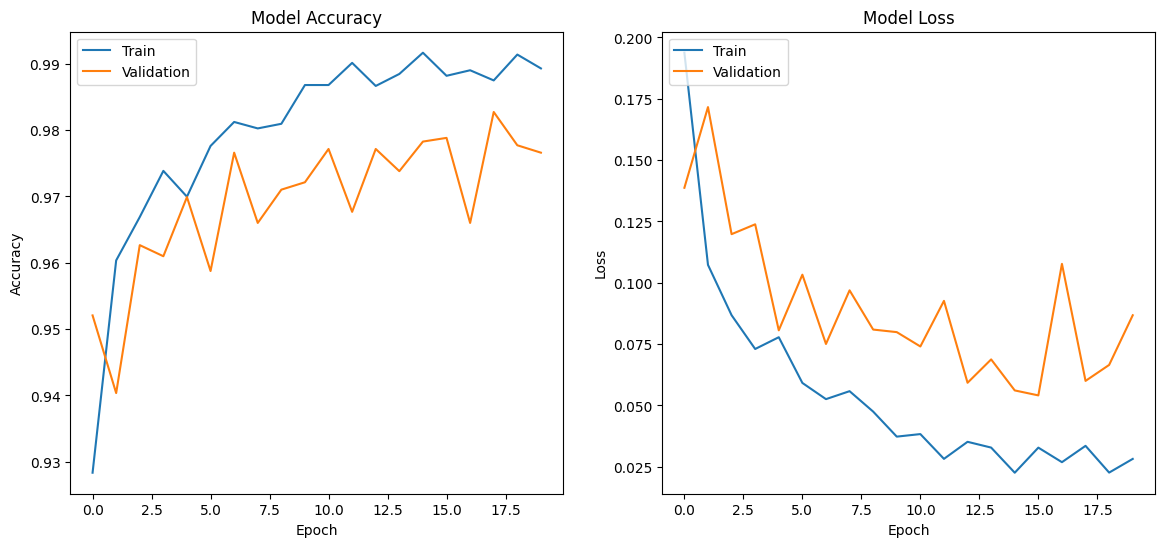

In [9]:
# Plot training & validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


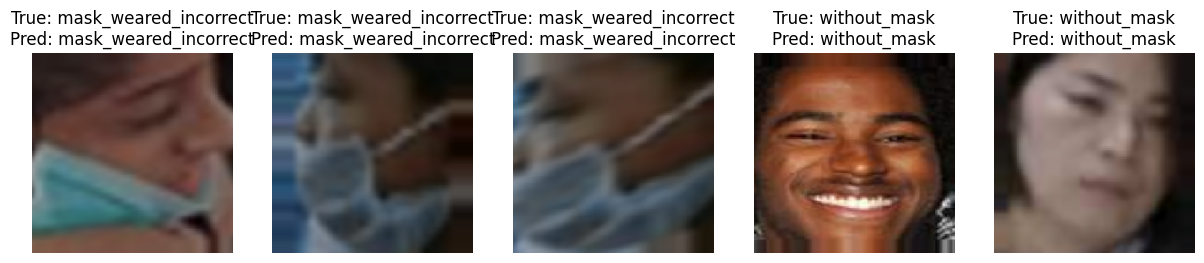

In [10]:
def visualize_predictions(generator, model, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.show()

visualize_predictions(validation_generator, model)


# Saving the Final Model
-----------------------------------------------------
- Save the final trained model to a file for future use or deployment.

In [11]:
model.save('/kaggle/working/mask_detection_model.keras')